# Model Definition and Training
The following code is used to define and compile the model. The various iterations of the model are then trained and validate on the appropiate data with all weights/models saved and graphed for analysis and evaluation at a later stage in the project.

First we import some of the packages we need:


In [1]:
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from keras import backend as K
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display 
from PIL import Image

Using TensorFlow backend.


## Define and Compile Model

The model is created using an architecture from Keras' applications package. This model loaded with the weights as appropriate and connected to a linearly activated output node (with some dropout applied for certain models) which will produce an MOS value. It is then compiled with the selected optimizer, saved and plotted to an image file.

In [21]:
from keras import models
from keras.layers import convolutional, pooling, core
from keras.models import Model
from keras import optimizers
#from keras.applications import ResNet50
#from keras.applications import VGG19
from keras.applications import VGG16
#from keras.applications import densenet
#from keras.applications import mobilenet
#from keras.applications.resnet_v2 import ResNet50V2
#from keras.applications import inception_v3
#from keras.layers.normalization import BatchNormalization
 
#base_model= inception_v3.InceptionV3(weights='imagenet',
#                 include_top=False, input_shape=(217,781,3))

#inception = inception_v3.InceptionV3(include_top = False, pooling='avg', weights ='imagenet', input_shape=(217, 781,3))
#resnet = ResNet50(include_top = False, pooling='avg', weights ='imagenet', input_shape=(217, 781,3))
#densenet = densenet.DenseNet121(include_top = False, pooling='avg', weights ='imagenet', input_shape=(217, 781,3))
#mobilenet = mobilenet.MobileNet(input_shape=(217, 781,3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet',  pooling='avg')
#vgg = VGG19(include_top = False, pooling='avg', weights ='imagenet', input_shape=(217, 781,3))
vgg2 = VGG16(include_top = False, pooling='avg', weights ='imagenet', input_shape=(217, 781,3))

model = models.Sequential()
#model.add(densenet)
model.add(vgg2)
#model.add(inception)
#model.add(mobilenet)
#model.add(resnet)
#model.add(core.Dropout(0.75))
#model.add(core.Dense(256, activation='relu'))
model.add(core.Dense(1, activation='linear'))
for layer in vgg2.layers[:]:
    layer.trainable=True
#for layer in resnet.layers[:-6]:
    
#model.layers[-4].trainable=False
model.compile(optimizer=optimizers.Adam(lr=1e-04), loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0), loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0), loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='mean_squared_error',  metrics=['mae'])





model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [41]:
filename = './models/vgg16_avg_NOdropoutFULL.h5'
model.save(filename)

In [ ]:
import pydot


plot_model(model, to_file='proposedmodel.png', show_shapes=True )

## Model Training
The csv containing the training features (spectrograms) and labels (POLQA MOS scores) is loaded into a dataframe and randomised. This randomised set of dataframe is then saved to csv to be loaded later in the  evaluation process. The imagedatagen object then splits the data into validation and training sets (20% and 80%) and identifies the images to be used for each stage. Any Data Augmentation is applied as a parameter of this model at this point.

In [44]:
#dfrand.to_csv('randomisedSWBscores2.csv',index=False)
dfrand=pd.read_csv('randomisedSWBscores.csv')
#dfrand.to_csv('randomisedNBscores.csv',index=False)
#dfrand=pd.read_csv('randomisedNBscores.csv')

In [ ]:
dfrand.head()

In [26]:
df=pd.read_csv('specswbfull2.csv', sep='\t')
#df=pd.read_csv('specNBfull2.csv', sep='\t')
pd.set_option('display.max_colwidth', -1)
dfrand=df.sample(frac=1)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
batch_size = 5

shift=0.2
#featurewise_center=False, featurewise_std_normalization=False, rotation_range=90, width_shift_range=shift, height_shift_range=shiftzca_whitening=True, horizontal_flip=True, -- for data aug
#contrast_stretching=True, adaptive_equalization=True, histogram_equalization=True, rotation_range=90, width_shift_range=shift, height_shift_range=shift, zca_whitening=True, horizontal_flip=True,
train_generator = datagen.flow_from_dataframe(
                                              dataframe=dfrand, directory='D:\\Spectrograms\\SWB_NB2\\', x_col="Spectrograms", y_col="MOS",
                                              target_size=(217,781), shuffle=True, batch_size=batch_size, class_mode='other', 
                                              subset='training')
validation_generator = datagen.flow_from_dataframe(dataframe=dfrand, directory='D:\\Spectrograms\\SWB_NB2\\', x_col="Spectrograms", y_col="MOS",
                                              target_size=(217,781), shuffle=True, batch_size=batch_size, class_mode='other', 
                                              subset='validation')   

Found 57686 images.
Found 14421 images.


The model is then fitted with the generators data and checkpointed to save the best results. The number of epochs and steps are also set below. After training and validation is complete, graphs showing the loss (MSE) and MAE are plotted and saved. The weights of the model are saved again as a backup. 

In [37]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from time import time
nb_epochs = 1

checkpointer = ModelCheckpoint(filepath='./models/vgg16_sm_nb_dropout_best.h5',
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir = './logs/vgg16nbdrop', 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

es = EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)

#model.load_weights("./models/vgg16avg_swbfinal2_trained.h5")
          
history = model.fit_generator(train_generator,
                    steps_per_epoch = train_generator.samples //  batch_size,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.samples // batch_size,
                    epochs = nb_epochs, verbose=1, callbacks=[checkpointer,tensorboard]) 

Epoch 1/1
11537/11537 [==============================] - 3705s 321ms/step - loss: 0.1954 - mean_absolute_error: 0.3328 - val_loss: 0.2514 - val_mean_absolute_error: 0.3682


In [40]:

model.save_weights("./models/vgg16avg_nb_trained_dropout.h5") 

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


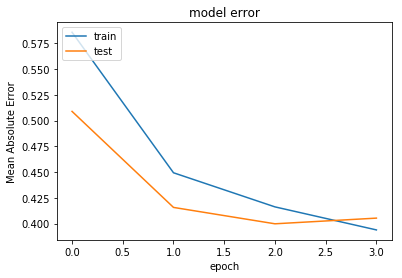

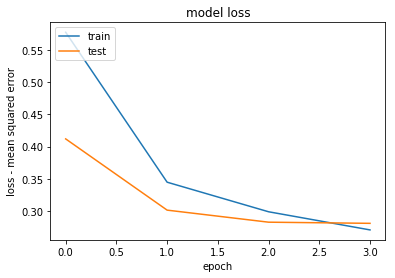

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('vggnbaccngbestSWBFINAL23123.png',bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss - mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('vgg16_nb_loss_bestSWBFINAL123123.png', bbox_inches='tight')
plt.show()